# **Test State Machine**

## **Initialization**

### **Code Setup**

In [158]:
from datetime import datetime, timedelta
import sys
from typing import Optional
from zoneinfo import ZoneInfo

from IPython.display import display
from matplotlib import pyplot as plt
import networkx as nx
import pandas as pd

# Add repo's python directory to PYTHONPATH so we can import our utilities
sys.path.append('../python/')

from s3l_utils.dataset import Dataset
from s3l_utils.notebook import print_md
from s3l_utils.functional import grouper

# Output formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Timezone abbreviation to zoneinfo
tz_abbrev_to_zoneinfo = {
    'PDT': ZoneInfo('US/Pacific'),
    'PST': ZoneInfo('US/Pacific'),
}

# Convert alarm times to proper datetimes... why is this so hard???
def alarm_time_to_datetime(alarm_time):
    if isinstance(alarm_time, datetime):
        return alarm_time

    components = alarm_time.split()
    naive_time = datetime.strptime(' '.join(components[:-1]), '%Y-%m-%d %H:%M:%S')
    aware_time = naive_time.astimezone(tz_abbrev_to_zoneinfo[components[-1][1:-1]])
    return aware_time

# Summarize table
def summarize_dataframe_md(df: pd.DataFrame, header: str = ''):
    if header:
        print_md(f'#### **{header}**')
    
    print_md(f'**Number of Rows:** {len(df)}')
    print_md(f'**Columns:** {", ".join(df.columns)}')

    print_md('#### **Unique Column Values**')
    for column in df.columns:
        unique_column_values = ', '.join(filter(None, map(str, list(df[column].unique()))))
        print_md(f'##### **{column.strip()}**')
        print_md(unique_column_values)

# Pandas options
# pd.set_option('display.max_rows', None)

### **Load and Prepare Dataset**

In [159]:
# Load dataset and tables
dataset = Dataset('../data/manifest.yml')
station_overview = dataset.stations.overview
alarms = dataset.reports.alarms
station_inventory = dataset.organizations.inventory.stations

# Canonicalize alarm times to US/Pacific datetimes
if not pd.api.types.is_datetime64_any_dtype(alarms['Alarm Time']):
    # alarms['Alarm Time'] = pd.to_datetime(alarms['Alarm Time'].map(lambda x: ' '.join(x.split()[:-1]))).dt.tz_localize('US/Pacific', ambiguous='NaT')
    dst_map = alarms['Alarm Time'].str.contains('PST')
    alarms['Alarm Time'] = pd.to_datetime(alarms['Alarm Time'].map(lambda x: ' '.join(x.split()[:-1]))).dt.tz_localize('US/Pacific', dst_map)

## **Analysis**

### **Functions**

In [160]:
def calculate_state_from_alarms(alarms,desired_mac = None, return_to_last_known_state=True):
    from chargepoint import ChargerModel, AlarmEnum

    # Mapping from MAC addresses to models. Each MAC address corresponds to one unique charger model.
    models: dict[str, ChargerModel] = {}

    if desired_mac is None:
        state_alarms = alarms.copy()
    else:
        state_alarms = alarms[alarms['MAC Address']==desired_mac].copy()
    state_alarms['State'] = ''

    # Iterate through all alarms chronologically and send to underlying charger state models. 
    for index, row in state_alarms.sort_values('Alarm Time').iterrows():
        mac = row['MAC Address']
        if mac in models:
            model = models[mac]
        else:
            model = ChargerModel(return_to_last_known_state=return_to_last_known_state)
            models[mac] = model
        
        alarm = AlarmEnum(row['Alarm Name'])
        model.send(alarm)
        state_alarms.loc[index, 'State'] = model.state.station_status.current_state.name

    return state_alarms

In [161]:
def build_state_history(state_alarms):
    # Sort state alarms by MAC Address and Alarm Time
    state_alarms = state_alarms.sort_values(['MAC Address', 'Alarm Time'])

    # For duplicate alarm times (for a given charger), only keep latest alarm
    state_alarms = state_alarms.drop_duplicates(['MAC Address', 'Alarm Time'], keep='last')

    state_history = None

    # Compute state history for each charger
    # Derived from:
    # https://www.codeforests.com/2021/03/30/group-consecutive-rows-in-pandas/
    # https://stackoverflow.com/questions/26911851/how-to-use-pandas-to-find-consecutive-same-data-in-time-series
    for mac, group in state_alarms.groupby('MAC Address'):
        group['Period'] = (group.State != group.State.shift()).cumsum()
        period_group = group.groupby('Period')
        charger_state_history = pd.DataFrame({
            'State': period_group.State.first(),
            'Start' : period_group['Alarm Time'].first(), 
            'End': period_group['Alarm Time'].last(),
            'Alarms': period_group.size()}).reset_index(drop=True)

        charger_state_history['MAC Address'] = mac
        charger_state_history['Period'] = charger_state_history.index

        # Fix up end times
        for index, row in charger_state_history.iterrows():
            try:
                charger_state_history.loc[index, 'End'] = charger_state_history.loc[index + 1, 'Start']
            finally:
                continue
        
        # Calculate durations
        charger_state_history['Duration'] = charger_state_history['End'] - charger_state_history['Start']
        
        # Order columns
        charger_state_history = charger_state_history[['MAC Address', 'Period', 'State', 'Start', 'End', 'Duration', 'Alarms']]

        # Concat
        if state_history is None:
            state_history = charger_state_history
        else:
            state_history = pd.concat([state_history, charger_state_history])
        
    
    return state_history


In [162]:
def build_states_duration(state_history):
    aux = state_history.copy()
    state_durations = aux.pivot_table(index='MAC Address', columns='State', values='Duration', aggfunc='sum', fill_value=pd.Timedelta(seconds=0))
    state_durations["Total"] = state_durations.sum(axis=1)
    state_percentages = state_durations.divide(state_durations['Total'], axis=0) * 100
    return state_durations, state_percentages

### **Uptime - Assuming Last Known Status**

In [163]:
return_to_last_known_state = True
state_alarms = calculate_state_from_alarms(alarms,return_to_last_known_state=return_to_last_known_state)

In [164]:
state_history = build_state_history(state_alarms)
# pd.set_option('display.max_rows', 100)
# state_history

In [165]:
state_durations, state_percentages = build_states_duration(state_history)
pd.set_option('display.max_rows', 100)
state_percentages

State,Available,Faulted,Unavailable,Unknown,Unreachable,Total
MAC Address,,,,,,
000D:6F00:04F8:B0AC,36.601582,40.142410,0.000000,0.0,23.256008,100.0
0024:B100:0002:13E5,93.474991,0.554936,0.014177,0.0,5.955896,100.0
0024:B100:0002:15D0,84.861482,7.792291,0.000394,0.0,7.345832,100.0
0024:B100:0002:15D4,87.829761,4.790399,0.001245,0.0,7.378595,100.0
0024:B100:0002:15DF,87.977949,5.003380,0.001101,0.0,7.017569,100.0
...,...,...,...,...,...,...
0024:B100:0006:C7DC,96.943220,2.821980,0.002737,0.0,0.232064,100.0
0024:B100:0006:C802,99.225203,0.002382,0.014863,0.0,0.757552,100.0
0024:B100:0006:C80C,99.594259,0.000000,0.014983,0.0,0.390758,100.0


In [166]:
display(pd.concat([state_percentages.mean(), state_percentages.std()], axis=1, keys=['Mean', 'Std. Dev.']))

,Mean,Std. Dev.
State,,
Available,85.584758,16.907438
Faulted,7.815756,13.577143
Unavailable,0.862589,2.995687
Unknown,0.000005,0.000060
Unreachable,5.736892,6.749624
Total,100.000000,0.000000


### **Uptime - Assuming Last Known Status FALSE**

In [167]:
return_to_last_known_state = False
state_alarms = calculate_state_from_alarms(alarms,return_to_last_known_state=return_to_last_known_state)

In [168]:
state_history = build_state_history(state_alarms)
# pd.set_option('display.max_rows', 100)
# state_history

In [169]:
state_durations, state_percentages = build_states_duration(state_history)
pd.set_option('display.max_rows', 100)
state_percentages

State,Available,Faulted,Unavailable,Unknown,Unreachable,Total
MAC Address,,,,,,
000D:6F00:04F8:B0AC,42.002419,34.741573,0.000000,0.0,23.256008,100.0
0024:B100:0002:13E5,93.475025,0.554902,0.014177,0.0,5.955896,100.0
0024:B100:0002:15D0,90.951219,1.702555,0.000394,0.0,7.345832,100.0
0024:B100:0002:15D4,91.079326,1.540834,0.001245,0.0,7.378595,100.0
0024:B100:0002:15DF,90.833373,2.147956,0.001101,0.0,7.017569,100.0
...,...,...,...,...,...,...
0024:B100:0006:C7DC,99.303086,0.462113,0.002737,0.0,0.232064,100.0
0024:B100:0006:C802,99.225203,0.002382,0.014863,0.0,0.757552,100.0
0024:B100:0006:C80C,99.594259,0.000000,0.014983,0.0,0.390758,100.0


In [170]:
display(pd.concat([state_percentages.mean(), state_percentages.std()], axis=1, keys=['Mean', 'Std. Dev.']))

,Mean,Std. Dev.
State,,
Available,86.609188,15.991962
Faulted,6.791326,12.790287
Unavailable,0.862589,2.995687
Unknown,0.000005,0.000060
Unreachable,5.736892,6.749624
Total,100.000000,0.000000


#### **Isolate Single MAC**

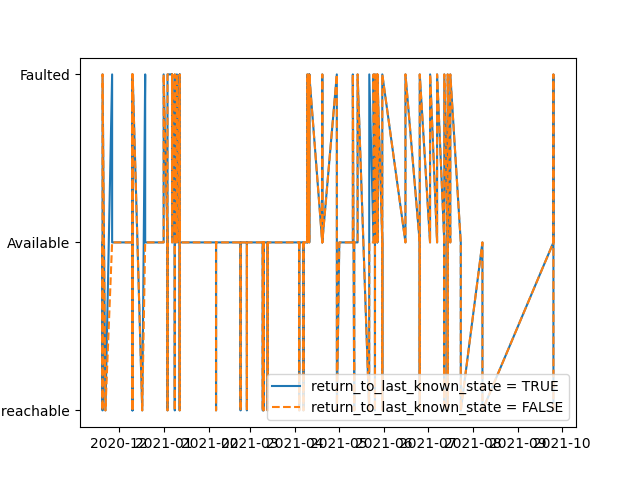

In [176]:
example_mac = '000D:6F00:04F8:B0AC'
state_alarms_1 = calculate_state_from_alarms(alarms,desired_mac=example_mac)
state_alarms_2 = calculate_state_from_alarms(alarms,desired_mac=example_mac,return_to_last_known_state=False)
plt.figure()
plt.plot(state_alarms_1['Alarm Time'],state_alarms_1['State'], label='return_to_last_known_state = TRUE')
plt.plot(state_alarms_2['Alarm Time'],state_alarms_2['State'],'--', label='return_to_last_known_state = FALSE')
plt.legend()
plt.show()

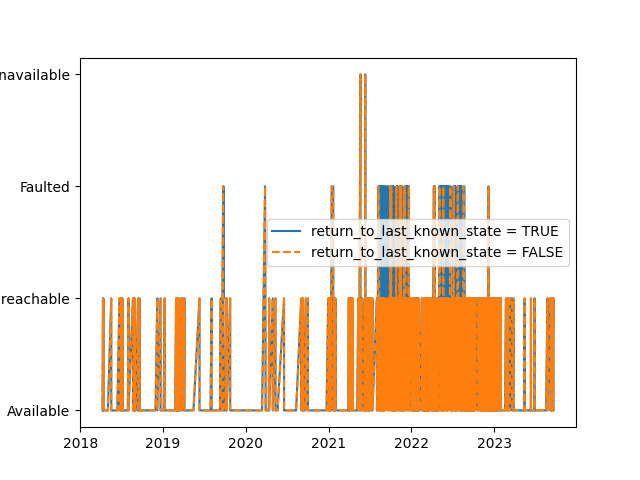

In [179]:
example_mac = '0024:B100:0002:15D0'
state_alarms_1 = calculate_state_from_alarms(alarms,desired_mac=example_mac)
state_alarms_2 = calculate_state_from_alarms(alarms,desired_mac=example_mac,return_to_last_known_state=False)
plt.figure()
plt.plot(state_alarms_1['Alarm Time'],state_alarms_1['State'], label='return_to_last_known_state = TRUE')
plt.plot(state_alarms_2['Alarm Time'],state_alarms_2['State'],'--', label='return_to_last_known_state = FALSE')
plt.legend()
plt.show()

- Boot alarms always transition to available
- Fault alarms always transition to faulted
- Fault cleared alarm transitions to available
- Unreachable alarms always transition to unreachable
- Reachable alarms transition to last known state (if enabled), 
- - Otherwise return to available
- Power off alarms transition to unavailable
- All other alarms essentially indicate the station is available


- Fault cleared with no previous fault case?
- False positives of alarms? Is this reasonable? 
- If you are unreachable and you come back to reachable, should we come back at the previous state or available (or ,yet, unknown)?
- Booting always come back to available?